In [1]:
# import environment
from marketsai.mon_policy.env_mon_infin_final import MonPolicy

from ray import tune, shutdown, init
from ray.tune.registry import register_env
from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import MultiAgentEpisode, RolloutWorker
from ray.rllib.policy import Policy
from ray.rllib.agents.ppo import PPOTrainer

# common imports
from scipy.stats import linregress
from typing import Dict
import numpy as np
import seaborn as sn
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import json
import math
import random


""" STEP 0: Experiment configs """
N_CPUS_DEVICE = 26 #number of cpus on device
DATE = "Jan2_"
ENV_LABEL = "mon_infin_LSTM"
OBS_IDSHOCK = True
INFL_REGIME = "low"
NATIVE = False
TEST = False
RUN_TRAINING = True
# in case there is no training
# INFO_ANALYSIS = "/Users/matiascovarrubias/Dropbox/RL_macro/Tests/expINFO_native_mon_fin_exp_0_Nov1_PPO_test.json"

sn.color_palette("Set2")

N_FIRMS = 2  # number of firms per industry
N_INDS = 100 # number of industries
N_INDS_EVAL = 100 # number of industries in evaluation simuls
ITERS_TEST = 10  # number of iteration for test
ITERS_RUN = 3000 # number of iteration for fullrun
ENV_HORIZON = 12 * 10 # horizon in training simulations
BETA = 0.95 ** (1 / 12)  # discount parameter
MARKUP_RANGE = [1,2.5] # range of allowed markups
NUM_POLICY = 4 # number of policies to train
EVAL_RESULTS = True # use evaluation results for analysis
LSTM_CELL = 128 # size of LSTM layer 
MEMORY = 12
EVAL_RESULTS = True

""" Paralleliztion and batch options"""
# Parallelization options
NUM_CPUS = N_CPUS_DEVICE-1
NUM_CPUS_DRIVER = 1
NUM_TRIALS = N_CPUS_DEVICE-1
NUM_PAR_TRIALS = N_CPUS_DEVICE-1
NUM_ROLLOUT = ENV_HORIZON * 1
NUM_ENV_PW = 1  # num_env_per_worker
NUM_GPUS = 0
BATCH_ROLLOUT = 1
NUM_MINI_BATCH = NUM_CPUS_DRIVER

N_WORKERS = (NUM_CPUS - NUM_PAR_TRIALS * NUM_CPUS_DRIVER) // NUM_PAR_TRIALS
BATCH_SIZE = NUM_ROLLOUT * (max(N_WORKERS, 1)) * NUM_ENV_PW * BATCH_ROLLOUT

print("number of workers:", N_WORKERS, "batch size:", BATCH_SIZE)

# define length of experiment (MAX_STEPS) and experiment name
if TEST == True:
    MAX_STEPS = ITERS_TEST * BATCH_SIZE
else:
    MAX_STEPS = ITERS_RUN * BATCH_SIZE

# checkpointing, evaluation during trainging and stopage
CHKPT_FREQ = 1000
if TEST:
    EVAL_HORIZON = ENV_HORIZON
    EVAL_INTERVAL = ITERS_TEST
    EVAL_EPISODES = 1
    SIMUL_EPISODES = 1
else:
    EVAL_HORIZON = 1200
    EVAL_INTERVAL = ITERS_RUN
    EVAL_EPISODES = 1
    SIMUL_EPISODES = 4

STOP = {"timesteps_total": MAX_STEPS}

""" Environment configuration """

# environment config including evaluation environment (without exploration)
env_config = {
    "horizon": ENV_HORIZON,
    "n_inds": N_INDS,
    "n_firms": N_FIRMS,
    "markup_min": MARKUP_RANGE[0],
    "markup_max": MARKUP_RANGE[1],
    "obs_idshock": OBS_IDSHOCK,
    "infl_regime": INFL_REGIME,
}


env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_eval["n_inds"] = N_INDS_EVAL
env_config_eval["horizon"] = EVAL_HORIZON

""" Custom metrics to pass to the algo configuration """
""" set custom metrics such as discounted rewards to keep track of through leraning"""
# Define custom metrics using the Callbacks class
# See rllib documentation on Callbacks. They are a way of inserting code in different parts of the pipeline.

# function to get discounted rewards for analysys
def process_rewards(r):
    """Compute discounted reward from a vector of rewards."""
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]


class MyCallbacks(DefaultCallbacks):
    def on_episode_start(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        # Make sure this episode has just been started (only initial obs
        # logged so far).

        assert episode.length == 0, (
            "ERROR: `on_episode_start()` callback should be called right "
            "after env reset!"
        )
        episode.user_data["rewards"] = []
        episode.user_data["markup_ij_avge"] = []
        episode.user_data["markup_agg"] = []
        episode.user_data["freq_p_adj"] = []
        episode.user_data["size_adj"] = []
        episode.user_data["log_c"] = []
        episode.user_data["profits"] = []

    def on_episode_step(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        if episode.length > 1:  # at t=0, previous rewards are not defined
            episode.user_data["rewards"].append(episode.prev_reward_for(0))

            episode.user_data["markup_ij_avge"].append(
                episode.last_info_for(0)["mean_mu_ij"]
            )
            episode.user_data["markup_agg"].append(
                episode.last_info_for(0)["mu"]
            )
            episode.user_data["freq_p_adj"].append(
                episode.last_info_for(0)["move_freq"]
            )
            episode.user_data["size_adj"].append(
                episode.last_info_for(0)["mean_p_change"]
            )
            episode.user_data["log_c"].append(episode.last_info_for(0)["log_c"])
            episode.user_data["profits"].append(
                episode.last_info_for(0)["mean_profits"]
            )

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: MultiAgentEpisode,
        env_index: int,
        **kwargs,
    ):
        episode.custom_metrics["discounted_rewards"] = process_rewards(
            episode.user_data["rewards"]
        )

        episode.custom_metrics["mean_markup_ij"] = np.mean(
            episode.user_data["markup_ij_avge"]
        )
        episode.custom_metrics["mean_mu_agg"] = np.mean(
            episode.user_data["markup_agg"]
        )

        episode.custom_metrics["freq_p_adj"] = np.mean(
            episode.user_data["freq_p_adj"]
        )
        episode.custom_metrics["size_adj"] = np.mean(
            episode.user_data["size_adj"]
        )
        episode.custom_metrics["std_log_c"] = np.std(
            episode.user_data["log_c"]
        )
        episode.custom_metrics["profits"] = np.mean(
            episode.user_data["profits"]
        )

""" Algorithm configuration """

# we instantiate the environment to extrac relevant info
" CHANGE HERE "
env = MonPolicy(env_config)

"""
NOTE: in order to do hyperparameter optimization, you can select a range of values 
with tune.choice([0.05,1] for random choice or tune.grid_search([0.05,1]) for fix search.
# see https://docs.ray.io/en/master/tune/key-concepts.html#search-spaces for spaces and their definition.
# se at the bottom (Annex_env_hyp) for an explanation how to do the same with environment parameters.
"""

# common configuration to all parameters
common_config = {
    # CUSTOM METRICS
    "callbacks": MyCallbacks,
    # ENVIRONMENT
    "gamma": BETA,
    "env": ENV_LABEL,
    "env_config": env_config,
    "horizon": ENV_HORIZON,
    # MODEL
    "framework": "torch",
    "model": {
        "fcnet_hiddens":[128,128],
        "use_lstm": True, 
        "lstm_cell_size": LSTM_CELL,
        "max_seq_len": MEMORY,
        #"lstm_use_prev_action": True,
        #"lstm_use_prev_reward": True,
        },
    # "model": tune.grid_search([{"use_lstm": True}, {"use_lstm": False}]),
    # TRAINING CONFIG
    "num_workers": N_WORKERS,
    "create_env_on_driver": False,
    "num_gpus": NUM_GPUS / NUM_PAR_TRIALS,
    "num_envs_per_worker": NUM_ENV_PW,
    "num_cpus_for_driver": NUM_CPUS_DRIVER,
    "rollout_fragment_length": NUM_ROLLOUT,
    "train_batch_size": BATCH_SIZE,
    # EVALUATION
    "evaluation_interval": EVAL_INTERVAL,
    "evaluation_num_episodes": EVAL_EPISODES,
    "evaluation_config": {
        "explore": False,
        "env_config": env_config_eval,
    },
    # MULTIAGENT,
    "multiagent": {
        "policies": {
            f"policy_{i}": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ) for i in range(NUM_POLICY)
        },
        "policy_mapping_fn": (
            lambda agent_id: f"policy_{agent_id%NUM_POLICY}"
        ),
        # "replay_mode": "independent",  # you can change to "lockstep".
        # OTHERS
    },
}

# Configs specific to the chosel algorithms, INCLUDING THE LEARNING RATE
ppo_config = {
    # "lr": 0.0001,
    "lr_schedule": [[0, 0.0005],[BATCH_SIZE*200, 0.0001], [BATCH_SIZE*2000, 0.00001]],
    "sgd_minibatch_size": BATCH_SIZE // NUM_MINI_BATCH,
    "num_sgd_iter": 1,
    "batch_mode": "complete_episodes",
    "lambda": 0.98,
    # "entropy_coeff": 0.0005,
    # "kl_coeff": 0,
    # "kl_target": 0, 
    # "vf_loss_coeff": 0.5,
    "vf_clip_param": float("inf"),
    # "entropy_coeff_schedule": [[0, 0.01], [5120 * 1000, 0]],
    "clip_param": 0.15,
    "clip_actions": True,
}

sac_config = {"prioritized_replay": False, "normalize_actions": False}

ALGO = "PPO"  # either PPO" or "SAC"
if NATIVE:
    device = "native_"  # either "native" or "server"
else:
    device = "server_"

if ALGO == "PPO":
    training_config = {**common_config, **ppo_config}
elif ALGO == "SAC":
    training_config = {**common_config, **sac_config}
else:
    training_config = common_config


if TEST:
    if NATIVE:
        OUTPUT_PATH_EXPERS = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
        )
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results/ALL/"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/ALL/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/ALL/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/ALL/"

else:
    if NATIVE:
        OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/"

    
# Initialize ray
shutdown()
init(
    num_cpus=N_CPUS_DEVICE,
    num_gpus=NUM_GPUS,
    log_to_driver=False,
)
# global configss
register_env(ENV_LABEL, MonPolicy)






number of workers: 0 batch size: 120


/scratch/mc5851/.cache/pypoetry/virtualenvs/marketsai-yL5UKpPI-py3.8/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [2]:
""" STEP 4: run training """

if RUN_TRAINING:
    exp_names = []
    trial_logdirs = []
    exp_dirs = []
    checkpoints = []
    configs = []

    rewards_eval = []
    mu_ij_eval = []
    mu_agg_eval = []
    freq_p_adj_eval = []
    size_adj_eval = []
    std_log_c_eval = []
    profits_eval = []

    rewards = []
    mu_ij = []
    mu_agg =[]
    freq_p_adj = []
    size_adj = []
    std_log_c = []
    profits = []

    # RUN TRAINER
    env_configs = []


    EXP_LABEL = device + ENV_LABEL + f"_exp_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + DATE + ALGO + "_test"
    else:
        EXP_NAME = EXP_LABEL + DATE + ALGO + "_run"


    analysis = tune.run(
        ALGO,
        name=EXP_NAME,
        config=training_config,
        stop=STOP,
        checkpoint_freq=CHKPT_FREQ,
        checkpoint_at_end=True,
        # metric="evaluation/custom_metrics/discounted_rewards_mean",
        # metric="custom_metrics/discounted_rewards_mean",
        # mode="max",
        num_samples=NUM_TRIALS,
        local_dir=OUTPUT_PATH_RESULTS,
        verbose=1,
        # resources_per_trial={"gpu": 0.5},
    )

    rewards_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "discounted_rewards_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_ij_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "mean_markup_ij_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_agg_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "mean_mu_agg_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    freq_p_adj_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "freq_p_adj_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    size_adj_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "size_adj_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )

    std_log_c_eval.append(
        [
            list(analysis.results.values())[i]["evaluation"]["custom_metrics"][
                "std_log_c_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )

    profits_eval.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["profits_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    rewards.append(
        [
            list(analysis.results.values())[i]["custom_metrics"][
                "discounted_rewards_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_ij.append(
        [
            list(analysis.results.values())[i]["custom_metrics"][
                "mean_markup_ij_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    mu_agg.append(
        [
            list(analysis.results.values())[i]["custom_metrics"][
                "mean_mu_agg_mean"
            ]
            for i in range(NUM_TRIALS)
        ]
    )
    freq_p_adj.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["freq_p_adj_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    size_adj.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["size_adj_mean"]
            for i in range(NUM_TRIALS)
        ]
    )

    std_log_c.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["std_log_c_mean"]
            for i in range(NUM_TRIALS)
        ]
    )

    profits.append(
        [
            list(analysis.results.values())[i]["custom_metrics"]["profits_mean"]
            for i in range(NUM_TRIALS)
        ]
    )
    exp_names.append(EXP_NAME)
    exp_dirs.append(analysis._experiment_dir)
    trial_logdirs.append([analysis.trials[i].logdir for i in range(NUM_TRIALS)])
    configs.append(
        [
            {
                "env_config": analysis.trials[i].config["env_config"],
                # "lr": analysis.trials[i].config["lr"],
                "lr_schedule": analysis.trials[i].config["lr_schedule"],
            }
            for i in range(NUM_TRIALS)
        ]
    )
    checkpoints.append(
        [analysis.trials[i].checkpoint.value for i in range(NUM_TRIALS)]
    )

    # learning_dta.append(
    #     analysis.best_dataframe[
    #         ["episodes_total", "evaluation/custom_metrics/discounted_rewards_mean"]
    #     ]
    # )
    
    # global experiment name
if len(exp_names) > 1:
    EXP_LABEL = device + f"_multiexp_"
    if TEST == True:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_test_" + DATE + ALGO
    else:
        EXP_NAME = EXP_LABEL + ENV_LABEL + "_run_" + DATE + ALGO

# create CSV with information on each experiment
exp_dict = {
    "n_agents": N_FIRMS,
    "exp_names": exp_names,
    "exp_dirs": exp_dirs,
    "trial_dirs": trial_logdirs,
    "checkpoints": checkpoints,
    "configs": configs,
    "results_eval": [
        rewards_eval,
        mu_ij_eval,
        mu_agg_eval,
        freq_p_adj_eval,
        size_adj_eval,
        std_log_c_eval,
        profits_eval,
    ],
    "results": [
        rewards,
        mu_ij,
        mu_agg,
        freq_p_adj,
        size_adj,
        std_log_c,
        profits,
    ],
}

print(
    "rewards:",
    rewards_eval,
    "\n",
    "mu_ij",
    mu_ij_eval,
    "\n",
    "freq_p_adj:",
    freq_p_adj_eval,
    "\n",
    "size_adj",
    size_adj_eval,
    "\n",
    "profits:",
    profits_eval,
    "\n",
    "std_log_c:",
    std_log_c_eval,
    "\n",
    "mu_agg",
    mu_agg_eval,
)

with open(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json", "w+") as f:
    json.dump(exp_dict, f)

# exp_df = pd.DataFrame(exp_dict)
# exp_df.to_csv(OUTPUT_PATH_EXPERS + "exp_info" + EXP_NAME + ".csv")
print(OUTPUT_PATH_EXPERS + "expINFO_" + EXP_NAME + ".json")

# erase progress.csv
for i in range(NUM_TRIALS):
    os.remove(trial_logdirs[0][i]+"/progress.csv")


2022-01-02 13:54:24,240	INFO tune.py:630 -- Total run time: 18003.73 seconds (18002.76 seconds for the tuning loop).


rewards: [[5.36039723609093, 10.962901845312897, 10.64545702352867, 12.963144527449595, 11.413263863959726, 10.220326002065695, 4.825405433398582, 8.77962824419709, 7.14326067695359, 7.6818449428331155, 2.8225028722798875, 5.1539282670901505, 10.659046910130579, 4.7422707414403025, 8.958846411759948, 9.868018960464289, 5.326654876467621, -12.540554830011079, 8.368081002524669, -9.086910017617118, 15.178126817976672, 6.068613146653892, 15.624513950398413, 7.031346323451258, 8.313243688385969]] 
 mu_ij [[1.319347441779688, 1.3677312170552227, 1.2930157986323754, 1.356012512871239, 1.3674972962744625, 1.3482915413987093, 1.3079669727534027, 1.3377340263759163, 1.3374514778775846, 1.3458367606352926, 1.252259858179537, 1.134857046326285, 1.383796232898326, 1.4016421661488458, 1.3193888381292749, 1.2445365664561738, 1.2851970122247316, 1.1642043353286848, 1.238634243141169, 1.1863578873058611, 1.4691048088760827, 1.2793314541244616, 1.3778165900740071, 1.3580732783292564, 1.2727174609047427

In [3]:
learning_dta = []

learning_dta.append(
    [
        list(analysis.trial_dataframes.values())[i][
            [
                # "episodes_total",
                "custom_metrics/discounted_rewards_mean",
                "custom_metrics/mean_markup_ij_mean",
                "custom_metrics/mean_mu_agg_mean",
                "custom_metrics/freq_p_adj_mean",
                "custom_metrics/size_adj_mean",
                "custom_metrics/std_log_c_mean",
                "custom_metrics/profits_mean",
            ]
        ]
        for i in range(NUM_TRIALS)
    ]
)
for i in range(NUM_TRIALS):
    learning_dta[0][i].columns = [
        # "episodes_total",
        f"discounted_rewards_trial_{i}",
        f"mu_ij_trial_{i}",
        f"mu_agg_trial_{i}",
        f"freq_p_adj_trial_{i}",
        f"size_adj_trial_{i}",
        f"std_log_c_trial_{i}",
        f"profits_trial_{i}",
    ]
    # learning_dta[0][i].set_index("episodes_total")
learning_dta_concat = pd.concat(learning_dta[0], axis=1)
learning_stats_dta = pd.DataFrame()
learning_stats_dta["rewards_avge"] = learning_dta_concat[[f"discounted_rewards_trial_{i}" for i  in range(NUM_TRIALS)]].mean(axis=1)
learning_stats_dta["rewards_std"] = learning_dta_concat[[f"discounted_rewards_trial_{i}" for i  in range(NUM_TRIALS)]].std(axis=1)
learning_stats_dta["rewards_upper"] = learning_stats_dta["rewards_avge"]+learning_stats_dta["rewards_std"]
learning_stats_dta["rewards_lower"] = learning_stats_dta["rewards_avge"]-learning_stats_dta["rewards_std"]
learning_stats_dta["mu_ij_avge"] = learning_dta_concat[[f"mu_ij_trial_{i}" for i  in range(NUM_TRIALS)]].mean(axis=1)
learning_stats_dta["mu_ij_std"] = learning_dta_concat[[f"mu_ij_trial_{i}" for i  in range(NUM_TRIALS)]].std(axis=1) 
learning_stats_dta["mu_ij_upper"] = learning_stats_dta["mu_ij_avge"]+learning_stats_dta["mu_ij_std"]
learning_stats_dta["mu_ij_lower"] = learning_stats_dta["mu_ij_avge"]-learning_stats_dta["mu_ij_std"]
learning_stats_dta["freq_p_adj_avge"] = learning_dta_concat[[f"freq_p_adj_trial_{i}" for i  in range(NUM_TRIALS)]].mean(axis=1)
learning_stats_dta["freq_p_adj_std"] = learning_dta_concat[[f"freq_p_adj_trial_{i}" for i  in range(NUM_TRIALS)]].std(axis=1)
learning_stats_dta["freq_p_adj_upper"] = learning_stats_dta["freq_p_adj_avge"]+learning_stats_dta["freq_p_adj_std"]
learning_stats_dta["freq_p_adj_lower"] = learning_stats_dta["freq_p_adj_avge"]-learning_stats_dta["freq_p_adj_std"]   
learning_stats_dta["size_adj_avge"] = learning_dta_concat[[f"size_adj_trial_{i}" for i  in range(NUM_TRIALS)]].mean(axis=1)
learning_stats_dta["size_adj_std"] = learning_dta_concat[[f"size_adj_trial_{i}" for i  in range(NUM_TRIALS)]].std(axis=1)
learning_stats_dta["size_adj_upper"] = learning_stats_dta["size_adj_avge"]+learning_stats_dta["size_adj_std"]
learning_stats_dta["size_adj_lower"] = learning_stats_dta["size_adj_avge"]-learning_stats_dta["size_adj_std"]     
learning_stats_dta["profits_avge"] = learning_dta_concat[[f"profits_trial_{i}" for i  in range(NUM_TRIALS)]].mean(axis=1)
learning_stats_dta["profits_std"] = learning_dta_concat[[f"profits_trial_{i}" for i  in range(NUM_TRIALS)]].std(axis=1)
learning_stats_dta["profits_upper"] = learning_stats_dta["profits_avge"]+learning_stats_dta["profits_std"]
learning_stats_dta["profits_lower"] = learning_stats_dta["profits_avge"]-learning_stats_dta["profits_std"]  
learning_stats_dta.to_csv(
    OUTPUT_PATH_EXPERS + "progress_" + exp_names[0] + ".csv"
)
# erase from ram
learning_dta = []
learning_dta_concat = []
analysis = []


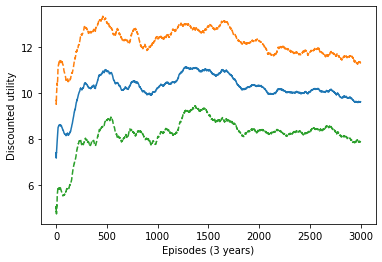

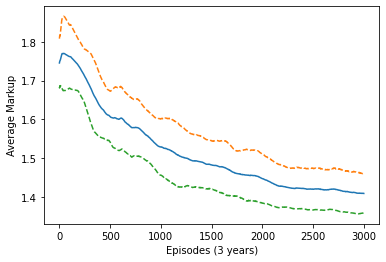

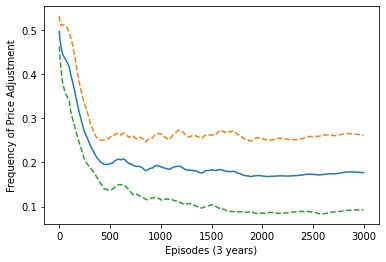

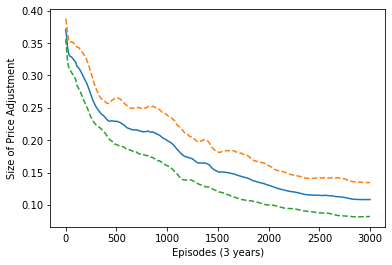

In [4]:
""" Organize and Plot progress data """

# Plot and save progress
if RUN_TRAINING:
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="rewards_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="rewards_upper",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="rewards_lower",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Episodes (3 years)")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_rewards" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_ij_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_ij_upper",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="mu_ij_lower",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Average Markup")
    plt.xlabel("Episodes (3 years)")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_mu_ij" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()


    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="freq_p_adj_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="freq_p_adj_upper",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="freq_p_adj_lower",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Frequency of Price Adjustment")
    plt.xlabel("Episodes (3 years)")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_freq_p_adj" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="size_adj_avge",
        x=learning_stats_dta.index,
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="size_adj_upper",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = sn.lineplot(
        data=learning_stats_dta,
        y="size_adj_lower",
        x=learning_stats_dta.index,
        linestyle='--'
    )
    learning_plot = learning_plot.get_figure()
    plt.ylabel("Size of Price Adjustment")
    plt.xlabel("Episodes (3 years)")
    learning_plot.savefig(
        OUTPUT_PATH_FIGURES + "progress_size_adj" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

Rewards: [  5.36039724  10.96290185  10.64545702  12.96314453  11.41326386
  10.220326     4.82540543   8.77962824   7.14326068   7.68184494
   2.82250287   5.15392827  10.65904691   4.74227074   8.95884641
   9.86801896   5.32665488 -12.54055483   8.368081    -9.08691002
  15.17812682   6.06861315  15.62451395   7.03134632   8.31324369]
results_stats: {'Mean Markups': 1.3099521129640532, 'S.D. Markups': 0.07548323205687728, 'Mean Agg. Markups': 1.1323885582017328, 'S.D. Agg. Markups': 0.09729894863883724, 'Mean Freq. of Adj.': 0.13876470588235296, 'S.D. Freq. of Adj.': 0.09244030628068352, 'Mean Size of Adj.': 0.12984041785536296, 'S.D. Size of Adj.': 0.05615631254856903, 'Mean S.D. of log C': 0.08451784397532762, 'S.D. S.D. of log C': 0.06093758116851901, 'Mean Profits': 0.10463733969035643, 'S.D. Profits': 0.010905854483083559}


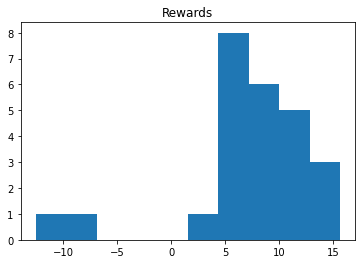

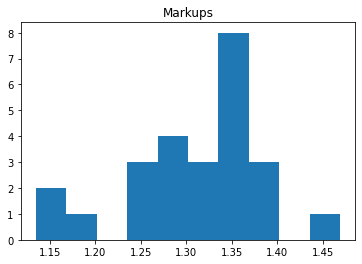

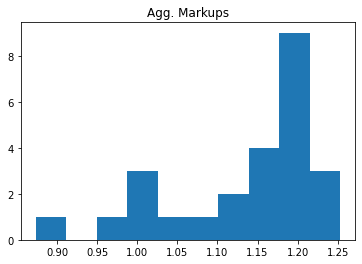

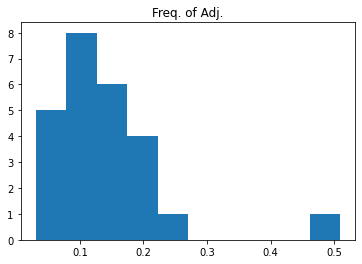

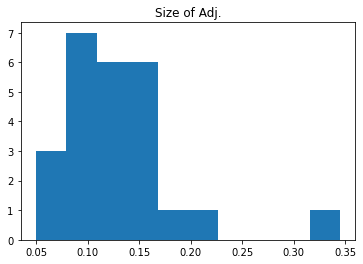

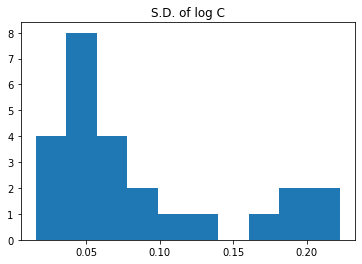

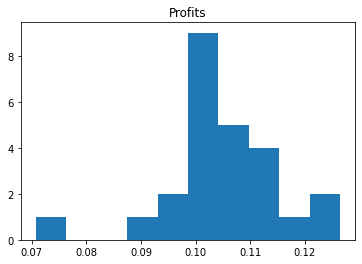

In [10]:
""" Step 5 Run Analysis """

# If there is no training, import exp info
if not RUN_TRAINING:
    with open(INFO_ANALYSIS) as f:
        exp_dict = json.load(f)
# Choose weather you want leval results or live results
if EVAL_RESULTS:
    results_data = exp_dict["results_eval"]
else:
    results_data = exp_dict["results"]
exp_names = exp_dict["exp_names"]
checkpoints = exp_dict["checkpoints"][0]
results = {
    "Rewards": np.array(results_data[0][0]),
    "Markups": np.array(results_data[1][0]),
    "Agg. Markups": np.array(results_data[2][0]),
    "Freq. of Adj.": np.array(results_data[3][0]),
    "Size of Adj.": np.array(results_data[4][0]),
    "S.D. of log C": np.array(results_data[5][0]),
    "Profits": np.array(results_data[6][0]),
}

results_stats = {
    "Mean Markups": np.mean(results["Markups"]),
    "S.D. Markups": np.std(results["Markups"]),
    "Mean Agg. Markups": np.mean(results["Agg. Markups"]),
    "S.D. Agg. Markups": np.std(results["Agg. Markups"]),
    "Mean Freq. of Adj.": np.mean(results["Freq. of Adj."]),
    "S.D. Freq. of Adj.": np.std(results["Freq. of Adj."]),
    "Mean Size of Adj.": np.mean(results["Size of Adj."]),
    "S.D. Size of Adj.": np.std(results["Size of Adj."]),
    "Mean S.D. of log C": np.mean(results["S.D. of log C"]),
    "S.D. S.D. of log C": np.std(results["S.D. of log C"]),
    "Mean Profits": np.mean(results["Profits"]),
    "S.D. Profits": np.std(results["Profits"]),
}
print("Rewards:", results["Rewards"])
print("results_stats:", results_stats)

# Plot histograms 
for i, x in results.items():
    plt.hist(x)
    plt.title(i)
    plt.savefig(
        OUTPUT_PATH_FIGURES + "hist_" + f"{i}" + "_" + exp_names[0] + ".png"
    )
    plt.show()
    plt.close()

    

Selected chekpoint; [1.3677312170552227, 0.08722689075630252, 0.12090544018671485, 0.06239353788567542, 1.2018064798541224]


2022-01-02 15:09:40,624	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2022-01-02 15:09:40,625	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-01-02 15:09:40,668	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-01-02 15:09:40,699	INFO trainable.py:416 -- Restored on 10.32.33.157 from checkpoint: /scratch/mc5851/ray_results/server_mon_infin_LSTM_exp_Jan2_PPO_run/PPO_mon_infin_LSTM_7c114_00001_1_2022-01-02_08-54-22/checkpoint_003000/checkpoint-3000
2022-01-02 15:09:40,700	INFO trainable.py:424 -- Current state after restoring: {'_iteration': 3000, '_timesteps_total': 0, '_time_total': 17203.3538274765, '_episodes_total': 3000}


[-1.9324152   0.06408089]


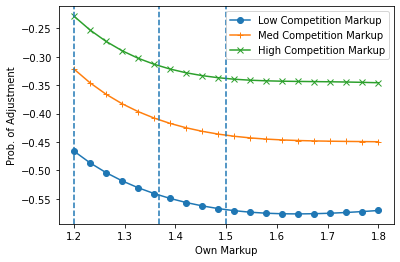

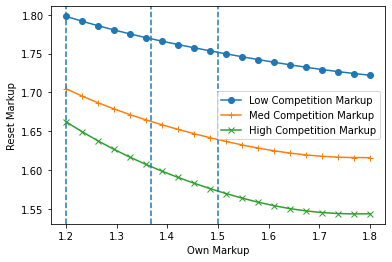

Slope of own react, low [-0.15189262515022642, -0.12516679830150682]
Slope of own react, med [-0.17992122968037924, -0.1487114454752633]
Slope of own react, high [-0.15584295136587964, -0.19845755025744444]


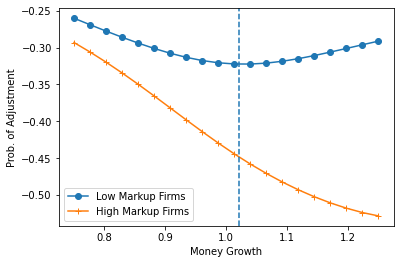

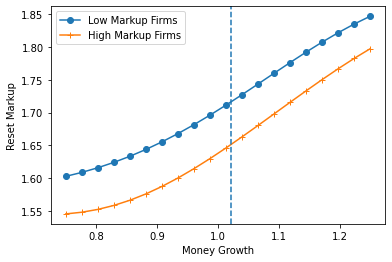

Slope to mon, low [-0.06034620489392963, -0.06034620489392963]
Slope to mon, high [-0.4995848962238856, 0.5399699507314445]


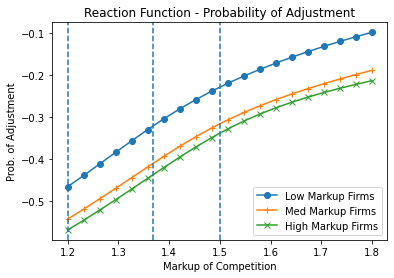

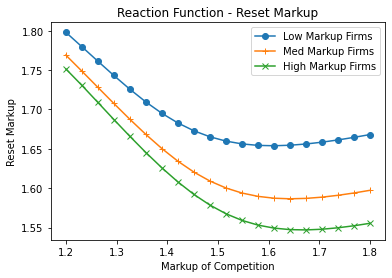

Slope of react, low [0.6138079166412356, -0.2087617064160961]
Slope of react, med [0.6013633921032863, -0.2877544946885403]
Slope of react, high [0.6123812908218024, -0.33478782044091676]


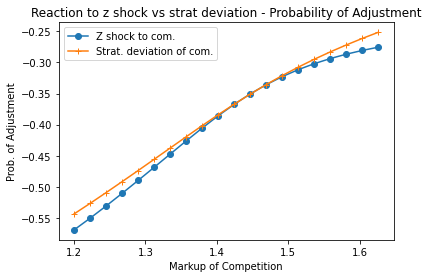

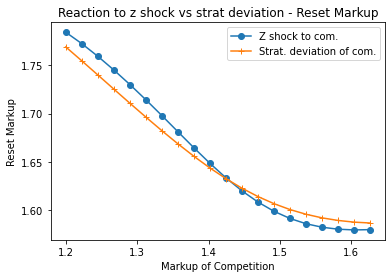

Slope of react to z shock [0.724922809474207, -0.5313442173528774]
Slope of react to strat. deviation [0.7050326327904394, -0.4466418982909976]


In [29]:
""" Inspect Policy Functions fo a given trial """

# Select trial to analyze
CHKPT_SELECT_REF = False
RESULTS_REF = np.array([results_stats["Mean Markups"], results_stats["Mean Freq. of Adj."], results_stats["Mean Size of Adj."]])
CHKPT_SELECT_MANUAL = True
CHKPT_id = 1
CHKPT_SELECT_MIN = False
CHKPT_SELECT_MAX = False
policy = "policy_3"
results_list = [
    [
        results["Markups"][i],
        results["Freq. of Adj."][i],
        results["Size of Adj."][i],
        results["S.D. of log C"][i],
        results["Agg. Markups"][i],
    ]
    for i in range(NUM_TRIALS)
]
if CHKPT_SELECT_REF:

    distance_agg = np.array(
        [
            (
                (results["Markups"][i] - RESULTS_REF[0])
                / results_stats["S.D. Markups"]
            )
            ** 2
            + (
                (results["Freq. of Adj."][i] - RESULTS_REF[1])
                / results_stats["S.D. Freq. of Adj."]
            )
            ** 2
            + (
                (results["Size of Adj."][i] - RESULTS_REF[2])
                / results_stats["S.D. Size of Adj."]
            )
            ** 2
            for i in range(NUM_TRIALS)
        ]
    )

    selected_id = distance_agg.argmin()

if CHKPT_SELECT_MIN:
    selected_id = results["Markups"].argmin()

if CHKPT_SELECT_MAX:
    selected_id = results["Rewards"].argmax()

if CHKPT_SELECT_MANUAL:
    selected_id = CHKPT_id

selected_stats = results_list[selected_id]
print("Selected chekpoint;", selected_stats)
INPUT_PATH_CHECKPOINT = checkpoints[selected_id]
shutdown()
init(
    num_cpus=N_CPUS_DEVICE,
    log_to_driver=False,
)

# register environment
env_label = "mon_policy_infin"
register_env(env_label, MonPolicy)
config_algo = training_config.copy()
config_algo["explore"] = False
trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Policy function with respect to own markup """

markup = [1.2 + (i / 19)*(0.6) for i in range(20)]
if not OBS_IDSHOCK:
    obs_reaction_lowmu = [
        np.array(
            [markup[i], 1.2] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [markup[i], selected_stats[0]] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [markup[i], 1.5] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
else:
    obs_reaction_lowmu = [
        np.array(
            [markup[i], 1.2, 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [markup[i], selected_stats[0], 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [markup[i], 1.5, 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]

# For LSTM
init_state = state = [
    np.zeros([LSTM_CELL], np.float32) for _ in range(2)
    ]

actions_reaction_lowmu = [
    trained_trainer.compute_action(obs_reaction_lowmu[i], state,  policy_id=policy)[0]
    for i in range(20)
]
actions_reaction_medmu = [
    trained_trainer.compute_action(obs_reaction_medmu[i], state,  policy_id=policy)[0]
    for i in range(20)
]
actions_reaction_highmu = [
    trained_trainer.compute_action(obs_reaction_highmu[i], state, policy_id=policy)[0]
    for i in range(20)
]

print(actions_reaction_lowmu[0])

move_prob_lowmu = [(actions_reaction_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_lowmu[i][1] + 1) / 2 for i in range(20)]
move_prob_medmu = [(actions_reaction_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_medmu[i][1] + 1) / 2 for i in range(20)]
move_prob_highmu = [(actions_reaction_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_highmu[i][1] + 1) / 2 for i in range(20)]

x = markup
plt.plot(x, move_prob_lowmu, '-o')
plt.plot(x, move_prob_medmu,'-+')
plt.plot(x, move_prob_highmu, '-x')
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=selected_stats[0], linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.legend(
    ["Low Competition Markup", "Med Competition Markup", "High Competition Markup"]
)
plt.xlabel("Own Markup")
plt.ylabel("Prob. of Adjustment")
# plt.title("Probability of Adjustment")
# plt.title("MIN")

plt.savefig(OUTPUT_PATH_FIGURES + "polown_prob_" + "_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu,'-o')
plt.plot(x, reset_medmu,'-+')
plt.plot(x, reset_highmu,'-x')
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=selected_stats[0], linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.legend(
    ["Low Competition Markup", "Med Competition Markup", "High Competition Markup"]
)
plt.xlabel("Own Markup")
plt.ylabel("Reset Markup")
# plt.title("Reset Markup")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polown_reset_" + "_" + exp_names[0] + ".png")
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup, reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of own react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of own react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of own react, high", [slope_react_prob_high, slope_react_reset_high])

""" Policy Function with respect to monetary policy. """

mon_policy = [0.75       
    + (i / 19) * 0.5
    for i in range(20)
]
# print(mon_policy)
if not OBS_IDSHOCK:
    obs_monpol_lowmu = [
        np.array([1.2, selected_stats[0]] + [selected_stats[4], mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_medmu = [
        np.array([selected_stats[0], selected_stats[0]] + [selected_stats[4], mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_highmu = [
        np.array([1.5, selected_stats[0]] + [selected_stats[4], mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
else:
    obs_monpol_lowmu = [
        np.array([1.2, selected_stats[0], 1, 1] + [selected_stats[4], mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_medmu = [
        np.array([selected_stats[0], selected_stats[0], 1, 1] + [selected_stats[4], mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_highmu = [
        np.array([1.5, selected_stats[0], 1, 1] + [selected_stats[4], mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]

actions_monpol_lowmu = [
    trained_trainer.compute_action(obs_monpol_lowmu[i], state,  policy_id=policy)[0]
    for i in range(20)
]
actions_monpol_medmu = [
    trained_trainer.compute_action(obs_monpol_medmu[i], state, policy_id=policy)[0]
    for i in range(20)
]
actions_monpol_highmu = [
    trained_trainer.compute_action(obs_monpol_highmu[i],  state, policy_id=policy)[0]
    for i in range(20)
]
move_prob_lowmu = [(actions_monpol_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_monpol_lowmu[i][1] + 1) / 2 for i in range(20)]
move_prob_medmu = [(actions_monpol_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_monpol_medmu[i][1] + 1) / 2 for i in range(20)]
move_prob_highmu = [(actions_monpol_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_monpol_highmu[i][1] + 1) / 2 for i in range(20)]
# print(actions_monpol_lowmu, "\n",
#     actions_monpol_highmu)
x = mon_policy
plt.plot(x, move_prob_lowmu, '-o')
# plt.plot(x,move_prob_medmu)
plt.plot(x, move_prob_highmu,'-+')
plt.axvline(x=1.0212, linestyle='--')
plt.legend(["Low Markup Firms", "High Markup Firms"])
plt.xlabel("Money Growth")
plt.ylabel("Prob. of Adjustment")
# plt.title("Effect of money growth on Prob. of Adj.")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polmon_prob_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu,'-o')
# plt.plot(x,reset_medmu)
plt.plot(x, reset_highmu,'-+')
plt.axvline(x=1.0212, linestyle='--')
plt.legend(["Low Markup Firms", "High Markup Firms"])
plt.xlabel("Money Growth")
plt.ylabel("Reset Markup")

# plt.title("Effec of money growth on Size of Adj.")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polmon_reset_" + exp_names[0] + ".png")
plt.show()
plt.close()

reg_mon_prob_low = linregress(mon_policy, move_prob_lowmu)
slope_mon_prob_low = reg_mon_prob_low[0]
reg_mon_prob_high = linregress(mon_policy, move_prob_highmu)
slope_mon_prob_high = reg_mon_prob_high[0]

reg_mon_reset_low = linregress(mon_policy, reset_lowmu)
slope_mon_reset_low = reg_mon_prob_low[0]
reg_mon_reset_high = linregress(mon_policy, reset_highmu)
slope_mon_reset_high = reg_mon_reset_high[0]

print("Slope to mon, low", [slope_mon_prob_low, slope_mon_reset_low])
print("Slope to mon, high", [slope_mon_prob_high, slope_mon_reset_high])

""" Reaction function to Competition Markup with constant z """

markup = [1.2 + (i / 19)*0.6 for i in range(20)]
if not OBS_IDSHOCK:
    obs_reaction_lowmu = [
        np.array(
            [1.2, markup[i]] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [selected_stats[0], markup[i]] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [1.5, markup[i]] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
else:
    obs_reaction_lowmu = [
        np.array(
            [1.2, markup[i], 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [selected_stats[0], markup[i], 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [1.5, markup[i], 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]

actions_reaction_lowmu = [
    trained_trainer.compute_action(obs_reaction_lowmu[i], state, policy_id=policy)[0]
    for i in range(20)
]
actions_reaction_medmu = [
    trained_trainer.compute_action(obs_reaction_medmu[i], state, policy_id=policy)[0]
    for i in range(20)
]
actions_reaction_highmu = [
    trained_trainer.compute_action(obs_reaction_highmu[i],  state, policy_id=policy)[0]
    for i in range(20)
]

move_prob_lowmu = [(actions_reaction_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_lowmu[i][1] + 1) / 2 for i in range(20)]
move_prob_medmu = [(actions_reaction_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_medmu[i][1] + 1) / 2 for i in range(20)]
move_prob_highmu = [(actions_reaction_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_highmu[i][1] + 1) / 2 for i in range(20)]

x = markup
plt.plot(x, move_prob_lowmu, '-o')
plt.plot(x, move_prob_medmu,'-+')
plt.plot(x, move_prob_highmu, '-x')
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=selected_stats[0], linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.legend(["Low Markup Firms", "Med Markup Firms", "High Markup Firms"])
plt.xlabel("Markup of Competition")
plt.ylabel("Prob. of Adjustment")
plt.title("Reaction Function - Probability of Adjustment")
plt.savefig(OUTPUT_PATH_FIGURES + "polreact_prob_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu, '-o')
plt.plot(x, reset_medmu,'-+')
plt.plot(x, reset_highmu, '-x')
plt.legend(["Low Markup Firms", "Med Markup Firms", "High Markup Firms"])
plt.xlabel("Markup of Competition")
plt.ylabel("Reset Markup")
plt.title("Reaction Function - Reset Markup")
plt.savefig(OUTPUT_PATH_FIGURES + "polreact_reset_" + exp_names[0] + ".png")
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup, reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of react, high", [slope_react_prob_high, slope_react_reset_high])

""" Reaction Function to comepition markup with changing z """
# markup = [1 + (i / 19) for i in range(20)]
if OBS_IDSHOCK:
    markup_z = [
        1.4
        / (
            math.e ** env.params["log_g_bar"]
            * math.e ** (4 * env.params["sigma_z"])
        )
        + (i / 19)
        * (
            1.4
            / (
                math.e ** env.params["log_g_bar"]
                * math.e ** (-4 * env.params["sigma_z"])
            )
            - 1.4
            / (
                math.e ** env.params["log_g_bar"]
                * math.e ** (4 * env.params["sigma_z"])
            )
        )
        for i in range(20)
    ]
    z = [
        math.e ** (4 * env.params["sigma_z"])
        + i
        / 19
        * (
            math.e ** (-4 * env.params["sigma_z"])
            - math.e ** (4 * env.params["sigma_z"])
        )
        for i in range(20)
    ]

    obs_reaction_zshock = [
        np.array(
            [selected_stats[0], markup_z[i], 1, z[i]] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_stratdev = [
        np.array(
            [selected_stats[0], markup_z[i], 1, 1] + [selected_stats[4], math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]

    actions_reaction_zshock = [
        trained_trainer.compute_action(
            obs_reaction_zshock[i], state, policy_id=policy)[0]
        for i in range(20)
    ]
    actions_reaction_stratdev = [
        trained_trainer.compute_action(
            obs_reaction_stratdev[i], state, policy_id=policy)[0]
        for i in range(20)
    ]

    move_prob_zshock = [(actions_reaction_zshock[i][0] + 1) / 2 for i in range(20)]
    reset_zshock = [MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_zshock[i][1] + 1) / 2 for i in range(20)]
    move_prob_stratdev = [
        (actions_reaction_stratdev[i][0] + 1) / 2 for i in range(20)
    ]
    reset_stratdev = [
        MARKUP_RANGE[0] + (MARKUP_RANGE[1]-MARKUP_RANGE[0])*(actions_reaction_stratdev[i][1] + 1) / 2 for i in range(20)
    ]

    x = markup_z
    plt.plot(x, move_prob_zshock,'-o')
    plt.plot(x, move_prob_stratdev,'-+')
    plt.legend(["Z shock to com.", "Strat. deviation of com."])
    plt.xlabel("Markup of Competition")
    plt.ylabel("Prob. of Adjustment")
    plt.title("Reaction to z shock vs strat deviation - Probability of Adjustment")
    plt.show()
    plt.close()

    plt.plot(x, reset_zshock,'-o')
    plt.plot(x, reset_stratdev,'-+')
    plt.legend(["Z shock to com.", "Strat. deviation of com."])
    plt.xlabel("Markup of Competition")
    plt.ylabel("Reset Markup")
    plt.title("Reaction to z shock vs strat deviation - Reset Markup")
    plt.show()
    plt.close()

    reg_react_prob_zshock = linregress(markup_z, move_prob_zshock)
    reg_react_reset_zshock = linregress(markup_z, reset_zshock)
    slope_react_prob_zshock = reg_react_prob_zshock[0]
    slope_react_reset_zshock = reg_react_reset_zshock[0]

    reg_react_prob_stratdev = linregress(markup_z, move_prob_stratdev)
    reg_react_reset_stratdev = linregress(markup_z, reset_stratdev)
    slope_react_prob_stratdev = reg_react_prob_stratdev[0]
    slope_react_reset_stratdev = reg_react_reset_stratdev[0]

    print(
        "Slope of react to z shock",
        [slope_react_prob_zshock, slope_react_reset_zshock],
    )
    print(
        "Slope of react to strat. deviation",
        [slope_react_prob_stratdev, slope_react_reset_stratdev],
    )

2022-01-02 13:57:37,580	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
2022-01-02 13:57:37,581	WARNING deprecation.py:38 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-01-02 13:57:37,622	WARNING util.py:57 -- Install gputil for GPU system monitoring.
2022-01-02 13:57:37,661	INFO trainable.py:416 -- Restored on 10.32.33.157 from checkpoint: /scratch/mc5851/ray_results/server_mon_infin_LSTM_exp_Jan2_PPO_run/PPO_mon_infin_LSTM_7c114_00020_20_2022-01-02_08-54-23/checkpoint_003000/checkpoint-3000
2022-01-02 13:57:37,661	INFO trainable.py:424 -- Current state after restoring: {'_iteration': 3000, '_timesteps_total': 0, '_time_total': 17002.342648744583, '_episodes_total': 3000}


time: 0
time: 120
time: 240
time: 360
time: 480
time: 600
time: 720
time: 840
time: 960
time: 1080
time: 1200
time: 1320
time: 1440
time: 1560
time: 1680
time: 1800
time: 1920
time: 2040
time: 2160
time: 2280
time: 2400
time: 2520
time: 2640
time: 2760
time: 2880
time: 3000
time: 3120
time: 3240
time: 3360
time: 3480
time: 3600
time: 3720
time: 3840
time: 3960
time: 4080
time: 4200
time: 4320
time: 4440
time: 4560
time: 4680
corr betweeen cons: [[1.         0.03091649]
 [0.03091649 1.        ]]
cum_IRs_freqlow: -0.38880650489090657 
 cum_IRs_freqhigh: 0.18505741976593665 
 cum_IRs_sizelow: -1.4471935565641096 
 cum_IRs_sizehigh: 3.2529187376270925 

Simul_results_dict: {'Mean Profits': [0.11549980925285358], 'S.D. Profits': [0.027612069173641705], 'Max Profits': [0.15687004837900032], 'Min Profits': [-0.16238396368425762], 'Mean Markups': [1.4691465793483933], 'S.D. Markups': [0.06433295630583637], 'Max Markups': [1.7073560754185657], 'Min Markups': [1.162652438120829], 'Mean Freq. of 

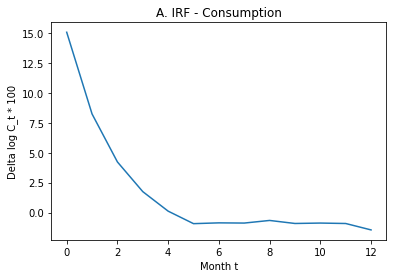

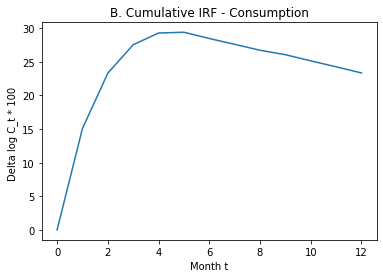

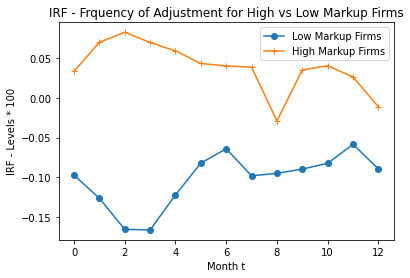

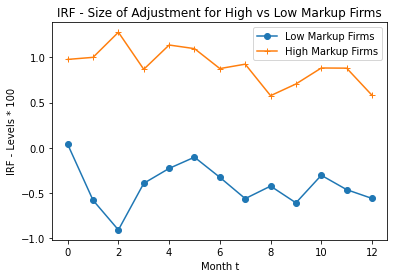

In [7]:
""" Simulate Episodes and Calculate Regressions"""

shutdown()
init(
    num_cpus=N_CPUS_DEVICE,
    log_to_driver=False,
)
# register environment
env_label = "mon_policy_infin"
register_env(env_label, MonPolicy)
# We instantiate the environment to extract information.
""" CHANGE HERE """
env_config_simul = env_config_eval.copy()
env_config_simul["random_eval"] = False
env_config_simul["horizon"] = SIMUL_EPISODES*EVAL_HORIZON
env_config_noagg = env_config_simul.copy()
env_config_noagg["no_agg"] = True
env = MonPolicy(env_config_simul)
env_noagg = MonPolicy(env_config_noagg)

""" Restore trainer """

# restore the trainer

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Simulate an episode (SIMUL_PERIODS timesteps) """
profits_list = []
mu_ij_list = []
freq_p_adj_list = []
size_adj_list = []
freq_adj_lowmu_list = []
freq_adj_highmu_list = []
size_adj_list = []
size_adj_lowmu_list = []
size_adj_highmu_list = []

log_c_list = []
epsilon_g_list = []

profits_list_noagg = []
mu_ij_list_noagg = []
freq_p_adj_list_noagg = []
freq_adj_lowmu_list_noagg = []
freq_adj_highmu_list_noagg = []
size_adj_list_noagg = []
size_adj_lowmu_list_noagg = []
size_adj_highmu_list_noagg = []
log_c_list_noagg = []

log_c_filt_list = []
freq_adj_lowmu_filt_list = []
freq_adj_highmu_filt_list = []
size_adj_lowmu_filt_list = []
size_adj_highmu_filt_list = []

# loop with agg
obs = env.reset()
obs_noagg = env_noagg.reset()
#initial state for LSTM
state = {
    i:[np.zeros([LSTM_CELL], np.float32) for _ in range(2)]
    for i in range(env.n_agents)
}
state_noagg = {
    i:[np.zeros([LSTM_CELL], np.float32) for _ in range(2)]
    for i in range(env.n_agents)
}
for t in range(SIMUL_EPISODES*EVAL_HORIZON):
    if t % 120 == 0:
        print("time:", t)
        # obs = env.reset()
        # obs_noagg = env_noagg.reset()
    action_returns = {
        i: trained_trainer.compute_action(obs[i], state[i], policy_id=f"policy_{i%NUM_POLICY}")
        for i in range(env.n_agents)
    }
    action_noagg_returns = {
        i: trained_trainer.compute_action(obs_noagg[i], state_noagg[i], policy_id=f"policy_{i%NUM_POLICY}")
        for i in range(env.n_agents)
    }
    action = {
        i: action_returns[i][0]
        for i in range(env.n_agents)
    }
    state = {
        i: action_returns[i][1]
        for i in range(env.n_agents)
    }
    action_noagg = {
        i: action_noagg_returns[i][0]
        for i in range(env.n_agents)
    }
    state_noagg = {
        i: action_noagg_returns[i][1]
        for i in range(env.n_agents)
    }

    obs, rew, done, info = env.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_noagg.step(action_noagg)

 
    profits_list.append(info[0]["mean_profits"])
    mu_ij_list.append(info[0]["mean_mu_ij"])
    freq_p_adj_list.append(info[0]["move_freq"])
    freq_adj_lowmu_list.append(info[0]["move_freq_lowmu"])
    freq_adj_highmu_list.append(info[0]["move_freq_highmu"])
    size_adj_list.append(info[0]["mean_p_change"])
    size_adj_lowmu_list.append(info[0]["size_adj_lowmu"])
    size_adj_highmu_list.append(info[0]["size_adj_highmu"])
    log_c_list.append(info[0]["log_c"])
    epsilon_g_list.append(env.epsilon_g)
    profits_list_noagg.append(info_noagg[0]["mean_profits"])
    mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
    freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
    freq_adj_lowmu_list_noagg.append(info_noagg[0]["move_freq_lowmu"])
    freq_adj_highmu_list_noagg.append(info_noagg[0]["move_freq_highmu"])
    size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
    size_adj_lowmu_list_noagg.append(info_noagg[0]["size_adj_lowmu"])
    size_adj_highmu_list_noagg.append(info_noagg[0]["size_adj_highmu"])
    log_c_list_noagg.append(info_noagg[0]["log_c"])
    log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
    freq_adj_lowmu_filt_list.append(
        freq_adj_lowmu_list[-1] - freq_adj_lowmu_list_noagg[-1]
    )
    freq_adj_highmu_filt_list.append(
        freq_adj_highmu_list[-1] - freq_adj_highmu_list_noagg[-1]
    )
    size_adj_lowmu_filt_list.append(
        size_adj_lowmu_list[-1] - size_adj_lowmu_list_noagg[-1]
    )
    size_adj_highmu_filt_list.append(
        size_adj_highmu_list[-1] - size_adj_highmu_list_noagg[-1]
    )


""" STEP 4, PLOT IRS and PROCESS RESULTS"""

simul_results_dict = {
    "Mean Profits": [],
    "S.D. Profits": [],
    "Max Profits": [],
    "Min Profits": [],
    "Mean Markups": [],
    "S.D. Markups": [],
    "Max Markups": [],
    "Min Markups": [],
    "Mean Freq. of Adj.": [],
    "S.D. Freq. of Adj.": [],
    "Max Freq. of Adj.": [],
    "Min Freq. of Adj.": [],
    "Mean Size of Adj.": [],
    "S.D. Size of Adj.": [],
    "Max Size of Adj.": [],
    "Min Size of Adj.": [],
    "S.D. log C": [],
    "IRs": [],
    "cum_IRs": [],
}

delta_log_c = [j - i for i, j in zip(log_c_filt_list[:-1], log_c_filt_list[1:])]

print(
    "corr betweeen cons:",
    np.corrcoef(log_c_list, log_c_list_noagg),
)
plt.plot(log_c_filt_list)
plt.title("A. Log C filtered")
# plt.show()
plt.close()

IRs = [0 for t in range(13)]
IRs_freqlow = [0 for t in range(13)]
IRs_freqhigh = [0 for t in range(13)]
IRs_sizelow = [0 for t in range(13)]
IRs_sizehigh = [0 for t in range(13)]
for t in range(0, 13):
    epsilon_g_reg = epsilon_g_list[: -(t + 1)] 
    delta_log_c_reg = delta_log_c[t:] 
    freq_adj_lowmu_reg = freq_adj_lowmu_list[t+1:]
    freq_adj_highmu_reg = freq_adj_highmu_list[t+1:]
    size_adj_lowmu_reg = size_adj_lowmu_list[t+1:] 
    size_adj_highmu_reg = size_adj_highmu_list[t+1:] 

    epsilon_g_reg_filt = [i for i in epsilon_g_reg if i > 0]
    delta_log_c_reg_filt = [
        delta_log_c_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    freq_adj_lowmu_reg_filt = [
        freq_adj_lowmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    freq_adj_highmu_reg_filt = [
        freq_adj_highmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    size_adj_lowmu_reg_filt = [
        size_adj_lowmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    size_adj_highmu_reg_filt = [
        size_adj_highmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    
    # regressions
    reg_c = linregress(delta_log_c_reg, epsilon_g_reg)
    IRs[t] = reg_c[0] * env.params["sigma_g"] * 100
    reg_freqlow = linregress(freq_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqlow[t] = reg_freqlow[0] * env.params["sigma_g"] * 100
    reg_freqhigh = linregress(freq_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqhigh[t] = reg_freqhigh[0] * env.params["sigma_g"] * 100
    reg_sizelow = linregress(size_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizelow[t] = reg_sizelow[0] * env.params["sigma_g"] * 100
    reg_sizehigh = linregress(size_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizehigh[t] = reg_sizehigh[0] * env.params["sigma_g"] * 100
cum_IRs = [np.sum(IRs[:t]) for t in range(13)]
cum_IRs_freqlow = [np.sum(IRs_freqlow[:t]) for t in range(13)]
cum_IRs_freqhigh = [np.sum(IRs_freqhigh[:t]) for t in range(13)]
cum_IRs_sizelow = [np.sum(IRs_sizelow[:t]) for t in range(13)]
cum_IRs_sizehigh = [np.sum(IRs_sizehigh[:t]) for t in range(13)]

print(
    "cum_IRs_freqlow:",
    cum_IRs_freqlow[3],
    "\n",
    "cum_IRs_freqhigh:",
    cum_IRs_freqhigh[3],
    "\n",
    "cum_IRs_sizelow:",
    cum_IRs_sizelow[3],
    "\n",
    "cum_IRs_sizehigh:",
    cum_IRs_sizehigh[3],
    "\n",
)

simul_results_dict["Mean Profits"].append(np.mean(profits_list))
simul_results_dict["S.D. Profits"].append(np.std(profits_list))
simul_results_dict["Max Profits"].append(np.max(profits_list))
simul_results_dict["Min Profits"].append(np.min(profits_list))
simul_results_dict["Mean Markups"].append(np.mean(mu_ij_list))
simul_results_dict["S.D. Markups"].append(np.std(mu_ij_list))
simul_results_dict["Max Markups"].append(np.max(mu_ij_list))
simul_results_dict["Min Markups"].append(np.min(mu_ij_list))
simul_results_dict["Mean Freq. of Adj."].append(np.mean(freq_p_adj_list))
simul_results_dict["S.D. Freq. of Adj."].append(np.std(freq_p_adj_list))
simul_results_dict["Max Freq. of Adj."].append(np.max(freq_p_adj_list))
simul_results_dict["Min Freq. of Adj."].append(np.min(freq_p_adj_list))
simul_results_dict["Mean Size of Adj."].append(np.mean(size_adj_list))
simul_results_dict["S.D. Size of Adj."].append(np.std(size_adj_list))
simul_results_dict["Max Size of Adj."].append(np.max(size_adj_list))
simul_results_dict["Min Size of Adj."].append(np.min(size_adj_list))
simul_results_dict["S.D. log C"].append(np.std(log_c_filt_list))
simul_results_dict["IRs"].append(IRs)
simul_results_dict["cum_IRs"].append(cum_IRs)
# simul_results_dict["IRs_freqlow"].append(IRs_freqlow)
# simul_results_dict["IRs_freqhigh"].append(IRs_freqhigh)
# simul_results_dict["IRs_sizelow"].append(IRs_sizelow)
# simul_results_dict["IRs_sizehigh"].append(IRs_sizehigh)

print("Simul_results_dict:", simul_results_dict)
# print(
#     "std_log_c:",
#     simul_results_dict["S.D. log C"],
#     "\n" + "mu_ij:",
#     simul_results_dict["Mean Markups"],
#     "\n" + "freq_p_adj:",
#     simul_results_dict["Mean Freq. of Adj."],
#     "\n" + "size_adj:",
#     simul_results_dict["Mean Size of Adj."],
#     "\n" + "mu_ij_final:",
#     simul_results_dict["Mean Flex. Markup"],
# )

""" Plot IRs """
x = [i for i in range(13)]
IRs = simul_results_dict["IRs"][-1]
plt.plot(x, IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.title("A. IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_" + exp_names[0] + ".png")
plt.show()
plt.close()

cum_IRs = simul_results_dict["cum_IRs"][-1]
plt.plot(x, cum_IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100 ")
plt.xlabel("Month t")
plt.title("B. Cumulative IRF - Consumption")
plt.savefig(OUTPUT_PATH_FIGURES + "cum_IRs_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_freqlow, '-o')
plt.plot(x, IRs_freqhigh, '-+')
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels * 100")
plt.xlabel("Month t")
plt.title("IRF - Frquency of Adjustment for High vs Low Markup Firms")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq_" + exp_names[0] + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_sizelow, '-o')
plt.plot(x, IRs_sizehigh, '-+')
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels * 100")
plt.xlabel("Month t")
plt.title("IRF - Size of Adjustment for High vs Low Markup Firms")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size_" + exp_names[0] + ".png")
plt.show()
plt.close()